# Exploratory: Which problems are most diagnostic of differences between the info and non-info models? 
Natalia Vélez, April 2022

In [1]:
%matplotlib inline
import sys, pprint
import numpy as np
import pandas as pd
import teaching_models as teach
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from ast import literal_eval
from scipy.stats import pearsonr,entropy,mannwhitneyu

sys.path.append('..')
from utils import gsearch, str_extract, int_extract, read_json

sns.set_context('talk')
sns.set_style('white')

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

## Load model predictions

Find MLE files:

In [2]:
param_files = gsearch('outputs/fit_model-*pref_cost_method-optimize/*.json')
param_files.sort()

print(f'Found {len(param_files)} files')
print(*param_files[-10:], sep='\n')
print('...')

Found 56 files
outputs/fit_model-pref_cost_method-optimize/sub-21_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-22_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-23_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-24_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-25_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-26_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-27_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-28_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-29_model-pref_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-30_model-pref_cost_method-optimize_result.json
...


Load MLE:

In [6]:
weights = {}

for f in param_files:
    # read model-fitting results
    res = read_json(f)

    # make subject-specific dict
    sub = int_extract('(?<=sub-)[0-9]{2}', f)
    if sub not in weights:
        weights[sub] = {}
        
    # save param_files
    model_name = str_extract('(?<=model-)[a-z_]+(?=_method-)', f)
    sub_w = np.array(res['x'])
    weights[sub][model_name] = sub_w
    
pprint.pprint(weights)

{1: {'info_pref_cost': array([ 0.08682452, 26.92077464,  2.75994875]),
     'pref_cost': array([27.13743707,  2.69584274])},
 2: {'info_pref_cost': array([1.12689429e-02, 1.17808207e+01, 2.97907311e+00]),
     'pref_cost': array([11.81174065,  2.9686911 ])},
 4: {'info_pref_cost': array([ 1.33021777, 22.69895661,  4.02278999]),
     'pref_cost': array([23.95576724,  3.59063683])},
 5: {'info_pref_cost': array([0.20254451, 8.80212628, 2.54752825]),
     'pref_cost': array([9.09469943, 2.52391791])},
 6: {'info_pref_cost': array([ 0.05806675, 31.32412117,  2.76783619]),
     'pref_cost': array([31.48587273,  2.71800423])},
 7: {'info_pref_cost': array([1.16181806e-14, 2.37553024e+01, 1.31432790e+00]),
     'pref_cost': array([23.7549836 ,  1.31466083])},
 8: {'info_pref_cost': array([ 0.0797263 , 23.65380052,  2.40645297]),
     'pref_cost': array([23.91047148,  2.36376948])},
 9: {'info_pref_cost': array([ 0.        , 15.08929169,  2.66616572]),
     'pref_cost': array([15.0885938 ,  2.

Helper function: Pad arrays for non-info model

In [4]:
def pad_weights(w):
    n_fit = len(w)
    return np.pad(w, (3-n_fit, 0), 'constant')

Helper function: Use parameter values, behavioral data to generate trial-by-trial predictions

In [7]:
# model_list = []
# all_models = ['info_pref_cost', 'pref_cost']

# for sub, sub_data in teach.human_df.groupby('subject'):
#     print('===== sub-%02d =====' % sub)
    
#     for m in all_models:
#         print(f'Model: {m}')
        
#         # get subject-specific weights
#         sub_fit_w = weights[sub][m]
#         sub_w = pad_weights(sub_fit_w) # pad non-info weights
#         print(f'{sub_w}\n')
        
#         # iterate over all problems
#         for prob, prob_data in sub_data.groupby('problem'):
#             preds = teach.utility_model_predictions(data=prob_data, 
#                                                     pref_fun=teach.edge_pref, 
#                                                     weights=sub_w)
#             preds_df = pd.DataFrame(preds)
#             preds_df['model'] = m
#             model_list.append(preds_df)

Check resulting dataframe

In [8]:
# model_df = pd.concat(model_list).reset_index(drop=True) # if running anew
model_df = pd.read_json('outputs/model_predictions.json', orient='records') # if loading cache
print(model_df.shape)
model_df.head()

(6426, 20)


,subject,run,block_idx,ex_idx,first_movement,start,problem,order,example,cursor_coords,example_coords,cursor,model,lik,pD,pTrue,pH,entropy,delta,KL
0,1,7,2,0,"[1, 5]","[0, 5]",0,"['C', 'D', 'A', 'B']",33,"[0, 5]","[5, 3]",5,info_pref_cost,0.025516,"[[0, 0.0], [1, 0.0], [2, 0.0675951533], [3, 0....",0.709270,"[[A, 0.7092697266], [B, 0.0], [C, 0.0], [D, 0....",0.602804,0.459270,0.783490
1,1,7,2,1,"[1, 5]","[0, 5]",0,"['C', 'D', 'A', 'B']",32,"[5, 3]","[5, 2]",33,info_pref_cost,0.100961,"[[0, 0.0], [1, 0.0], [2, 0.0278509906], [3, 0....",0.346161,"[[A, 0.3461611284], [B, 0.0], [C, 0.0], [D, 0....",0.645038,-0.363109,0.281601
2,1,7,2,2,"[1, 5]","[0, 5]",0,"['C', 'D', 'A', 'B']",2,"[5, 2]","[0, 2]",32,info_pref_cost,0.041067,"[[0, 0.0], [1, 0.0], [2, 0.0410671598], [3, 0....",1.000000,"[[A, 1.0], [B, 0.0], [C, 0.0], [D, 0.0]]",0.000000,0.653839,1.060851
3,1,1,2,0,"[5, 4]","[5, 5]",1,"['A', 'D', 'C', 'B']",31,"[5, 5]","[5, 1]",35,info_pref_cost,0.066569,"[[0, 0.0], [1, 0.0220738095], [2, 0.0075711726...",0.030642,"[[A, 0.0306419933], [B, 0.48467900340000003], ...",0.808875,-0.219358,0.577420
4,1,1,2,1,"[5, 4]","[5, 5]",1,"['A', 'D', 'C', 'B']",1,"[5, 1]","[0, 1]",31,info_pref_cost,0.084346,"[[0, 0.0], [1, 0.0843463431], [2, 0.0151310999...",1.000000,"[[A, 1.0], [B, 0.0], [C, 0.0], [D, 0.0]]",0.000000,0.969358,3.485384


Save model predictions to a file so we don't have to run this again :) 

In [ ]:
# model_df.to_json('outputs/model_predictions.json', orient='records')

Read from JSON

## Compare sampling distributions for each problem

Helper function: Convert `pD` entry to dataframe

In [9]:
def pD_to_dataframe(pD):
    df = pd.DataFrame(pD, columns=['idx', 'A']).set_index('idx')
    return df

Helper function: Get KL divergences between models for a specific observation

In [10]:
def model_KL(group):

    obs_dict = {}

    # Get sampling distributions
    for _, row in group.iterrows():
        # Load problem to filter
        prob_idx = row.problem
        prob = teach.problem_df(prob_idx)
        prob_filter = prob.A == 1

        # Read out values
        pD = pD_to_dataframe(row.pD)
        pD = pD.loc[prob_filter]
        obs_dict[row.model] = pD.values

    # Compute KL divergence between distributions
    KL = entropy(obs_dict['info_pref_cost'], obs_dict['pref_cost'])
    return KL[0]

Main loop: Compute KL divergences

In [11]:
KL_list = []
for (sub, prob, ex_idx),group in model_df.groupby(['subject', 'problem', 'ex_idx']):
    KL = model_KL(group)
    KL_list.append((sub, prob, ex_idx, KL))

In [12]:
KL_df = pd.DataFrame(KL_list, columns=['subject', 'problem', 'ex_idx', 'KL'])
print(KL_df.shape)
KL_df.head()

(3213, 4)


,subject,problem,ex_idx,KL
0,1,0,0,0.001721
1,1,0,1,0.000640
2,1,0,2,0.000757
3,1,1,0,0.007526
4,1,1,1,0.107616


Average KL divergence by problem:

<AxesSubplot:xlabel='problem', ylabel='KL'>

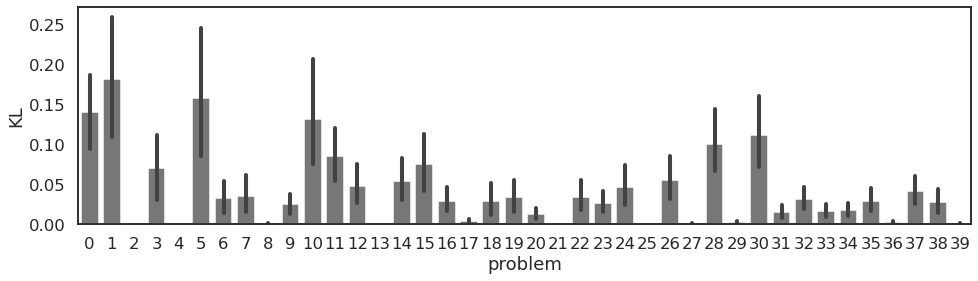

In [13]:
fig,ax = plt.subplots(figsize=(16,4))
sns.barplot(data=KL_df,x='problem', y='KL', ax=ax, fc='#777')

Distribution of KL divergences:

[(0.0, 0.2650549601108639)]

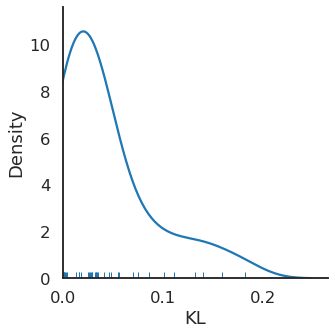

In [14]:
avg_KL = KL_df.groupby('problem').agg({'KL': 'mean'}).reset_index()
g = sns.displot(data=avg_KL, x='KL', kind='kde', rug=True)
g.ax.set(xlim=(0,None))

Helper function: Plot problem

In [15]:
def plot_problem(prob_idx):
    prob = teach.problems[prob_idx]
    prob_labels = list(prob.keys())
    fig,axes=plt.subplots(1,4, figsize=(16,4))


    for key,val in prob.items():
        ax_idx = prob_labels.index(key)
        sns.heatmap(val, cmap='Greys', square=True, cbar=False, ax=axes[ax_idx], lw=1, linecolor='#aaa')
        axes[ax_idx].set(xticklabels=[], yticklabels=[], title=key)
        
    fig.suptitle(f'Problem {prob_idx}')

Most diagnostic problems:

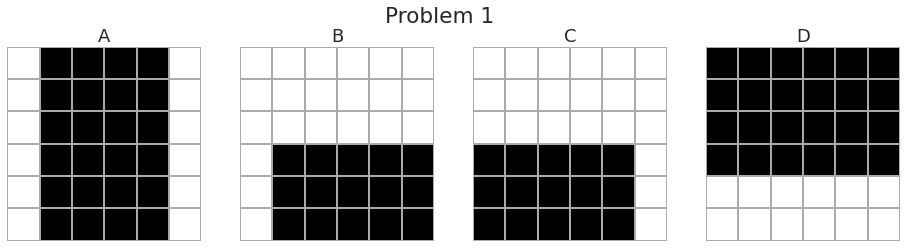

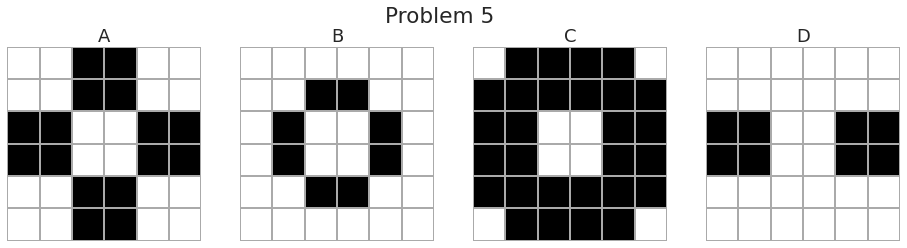

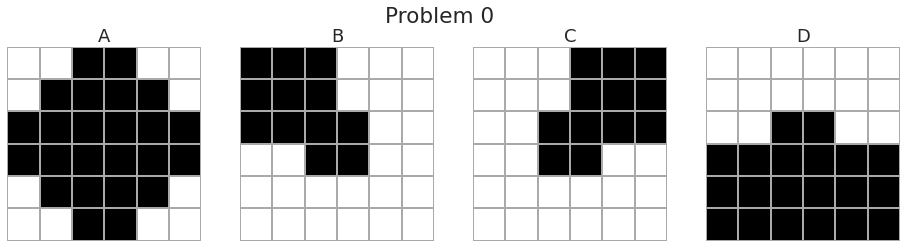

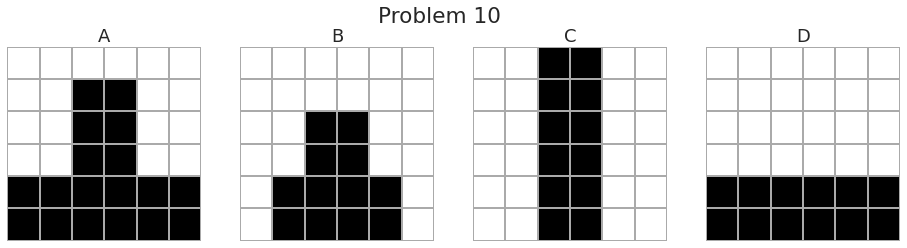

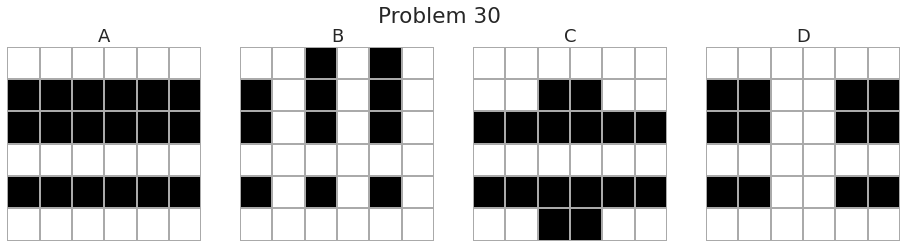

In [16]:
sorted_KL = avg_KL.sort_values(by='KL', ascending=True)
most_diagnostic = sorted_KL.tail(5).problem.values

for prob_idx in most_diagnostic[::-1]:
    plot_problem(prob_idx)

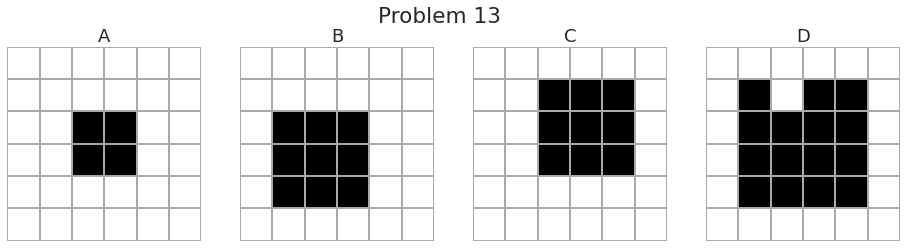

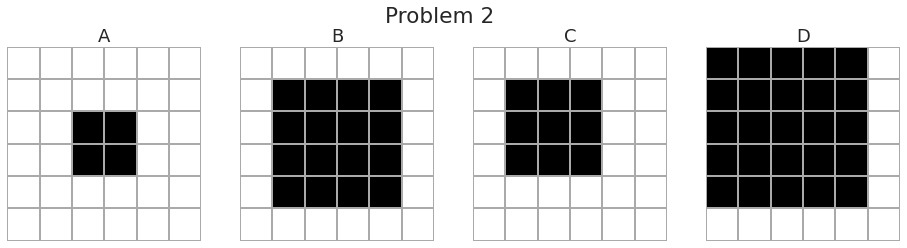

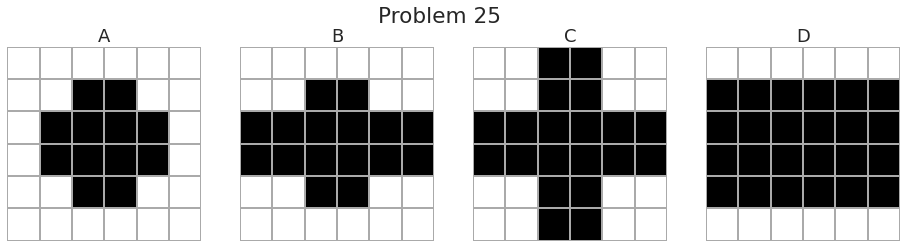

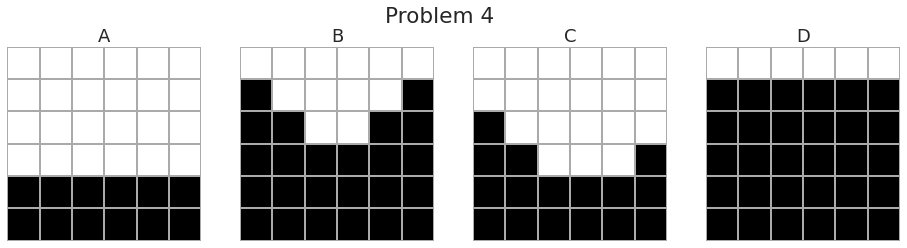

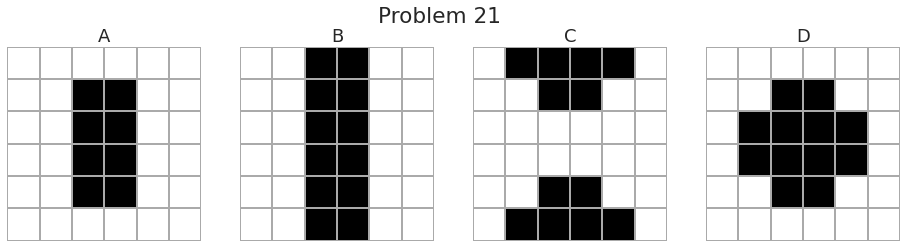

In [17]:
least_diagnostic = sorted_KL.head(5).problem.values

for prob_idx in least_diagnostic:
    plot_problem(prob_idx)

## Sanity check: Do models diverge in problems where the right answer cannot be uniquely identified?

Helper function: Does correct answer contain points that uniquely identify it?

In [18]:
def problem_identifiability(prob_idx):

    # convert each hypothesis into the indices of the black squares
    prob = teach.problems[prob_idx]
    _, values = list(zip(*prob.items()))
    nonzero_idx = [np.ravel_multi_index(np.nonzero(p), (6,6)) for p in values]

    # compare each alternative hypothesis against the true one
    is_identifiable = True
    for alt in nonzero_idx[1:]:
        unique_points = np.setdiff1d(nonzero_idx[0], alt)
        if not len(unique_points):
            is_identifiable = False
            break
    
    return is_identifiable

In [19]:
ident_df = pd.DataFrame([(idx, problem_identifiability(idx)) for idx in range(40)], columns=['problem', 'identifiable'])
ident_df = ident_df.merge(avg_KL)
ident_df.head()

,problem,identifiable,KL
0,0,True,0.139883
1,1,True,0.181885
2,2,False,0.000091
3,3,False,0.070523
4,4,False,0.000739


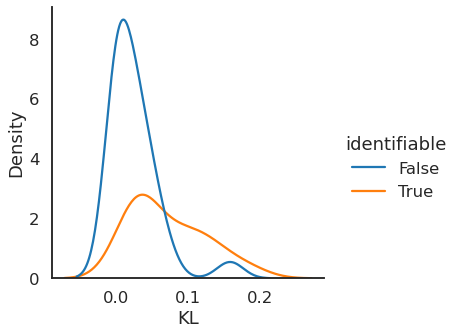

In [20]:
sns.displot(data=ident_df, x='KL', hue='identifiable', kind='kde')

In [21]:
ident_df.groupby('identifiable').agg({'problem': 'count', 'KL': ['median', 'mean']})

problem        KL          
               count    median      mean
identifiable                            
False             25  0.015810  0.025507
True              15  0.048332  0.071829

In [22]:
mannwhitneyu(ident_df[ident_df.identifiable == True].KL, ident_df[ident_df.identifiable == False].KL)

MannwhitneyuResult(statistic=74.0, pvalue=0.0007972666021262133)

Helper function: Size of true hypothesis

In [23]:
def true_size(prob_idx):
    prob = teach.problems[prob_idx]
    h_true = prob['A']

    return np.sum(h_true)

In [24]:
size_df = pd.DataFrame([(i, true_size(i)) for i in range(40)], columns=['problem', 'size'])
size_df = size_df.merge(ident_df)
size_df.head()

,problem,size,identifiable,KL
0,0,24,True,0.139883
1,1,24,True,0.181885
2,2,4,False,0.000091
3,3,24,False,0.070523
4,4,12,False,0.000739


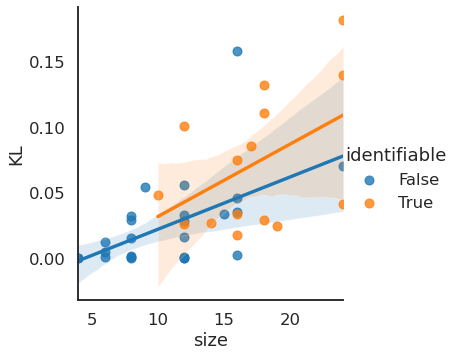

In [25]:
sns.lmplot(data=size_df, x='size', y='KL', hue='identifiable')

## Plot predictions for some diagnostic cases

Find the most and least information-maximizing participants:

In [26]:
model_fits = pd.read_csv('outputs/second_level_model_regressors.csv').sort_values(by='logBF')
model_fits.head()

,subject,logBF
19,22,-1.056438
5,7,-1.052788
25,28,-1.052788
7,9,-1.049076
13,15,-1.039509


In [27]:
most_info = model_fits.subject.values[-1] # pick out extremes
least_info = model_fits.subject.values[0]

Helper: Plot predictions for a given problem

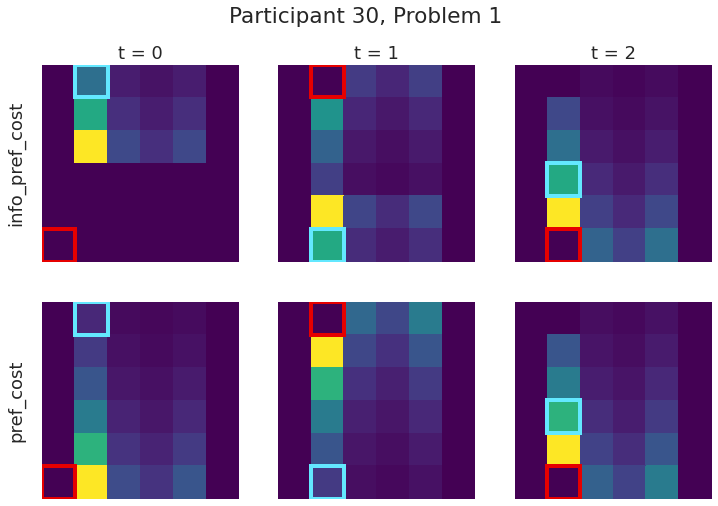

In [33]:
sub = most_info
prob_idx = 1

prob_data = model_df[(model_df.subject == sub) & (model_df.problem == prob_idx)]
models = prob_data.model.unique()
timepoints = prob_data.ex_idx.unique()

fig, axes = plt.subplots(len(models), len(timepoints), figsize=(12, 8))
for m_idx, m in enumerate(models):
    model_data = prob_data[prob_data.model == m]
    for _, row in model_data.iterrows():
        pD = pd.DataFrame(row.pD, columns=['idx', 'A'])
        pD = pD.set_index('idx')
        
        # plot heatmap
        pD_mtx = teach.sampling_matrix(pD)
        sns.heatmap(pD_mtx, cmap='viridis', cbar=False, square=True, ax=axes[m_idx, row.ex_idx])
        axes[m_idx, row.ex_idx].set(xticklabels=[], yticklabels=[])
        
        if row.ex_idx == 0:
            axes[m_idx, row.ex_idx].set(ylabel=m)
            
        if m_idx == 0:
            axes[m_idx, row.ex_idx].set(title = f't = {row.ex_idx}')
        
        # draw square over cursor locations
        start = np.unravel_index(row.cursor, (6,6))
        end = np.unravel_index(row.example, (6,6))
        
        axes[m_idx, row.ex_idx].add_patch(patches.Rectangle(start[::-1], 1, 1, edgecolor='#e60000', lw=4, fill=None))
        axes[m_idx, row.ex_idx].add_patch(patches.Rectangle(end[::-1], 1, 1, edgecolor='#63e8ff', lw=4, fill=None))
        
        # label figure
        fig.suptitle(f'Participant {sub}, Problem {prob_idx}')